# Building a Deep Neural Network: Step by Step

**My notation in this notebook**:
- Superscript $[l]$ denotes a quantity associated with the $l^{th}$ layer.
    - Example: $a^{[L]}$ is the $L^{th}$ layer activation. $W^{[L]}$ and $b^{[L]}$ are the $L^{th}$ layer parameters.
- Superscript $(i)$ denotes a quantity associated with the $i^{th}$ example.
    - Example: $x^{(i)}$ is the $i^{th}$ training example.
- Lowerscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the $l^{th}$ layer's activations).

## Table of Contents
- [1 - Packages](#1)
- [2 - Outline](#2)
- [3 - Initialization](#3)
    - [3.1 - 2-layer Neural Network](#3-1)
    - [3.2 - L-layer Neural Network](#3-2)
- [4 - Forward Propagation Module](#4)
    - [4.1 - Linear Forward](#4-1)
    - [4.2 - Linear-Activation Forward](#4-2)
    - [4.3 - L-Layer Model](#4-3)
- [5 - Cost Function](#5)
- [6 - Backward Propagation Module](#6)
    - [6.1 - Linear Backward](#6-1)
    - [6.2 - Linear-Activation Backward](#6-2)
    - [6.3 - L-Model Backward](#6-3)
    - [6.4 - Update Parameters](#6-4)

<a name='1'></a>
## 1 - Packages

In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from testCases import *
from dnn_utils import sigmoid, sigmoid_backward, relu, relu_backward
from public_tests import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

<a name='2'></a>
## 2 - Outline

Here's an outline of the steps I followed to build the necessary helper functions/neural network sub-blocks:

- Initialize the parameters for a two-layer network and for an $L$-layer neural network
- Implement the forward propagation module
     - Complete the LINEAR part of a layer's forward propagation step (resulting in $Z^{[l]}$).
     - Combine the previous step into a new [LINEAR->ACTIVATION] forward function.
     - Stack the [LINEAR->RELU] forward function L-1 time (for layers 1 through L-1) and add a [LINEAR->SIGMOID] at the end (for the final layer $L$)
- Compute the loss
- Implement the backward propagation module
    - Complete the LINEAR part of a layer's backward propagation step
    - Combine the previous steps into a new [LINEAR->ACTIVATION] backward function
    - Stack [LINEAR->RELU] backward L-1 times and add [LINEAR->SIGMOID] backward in a new L_model_backward function
- Finally, update the parameters

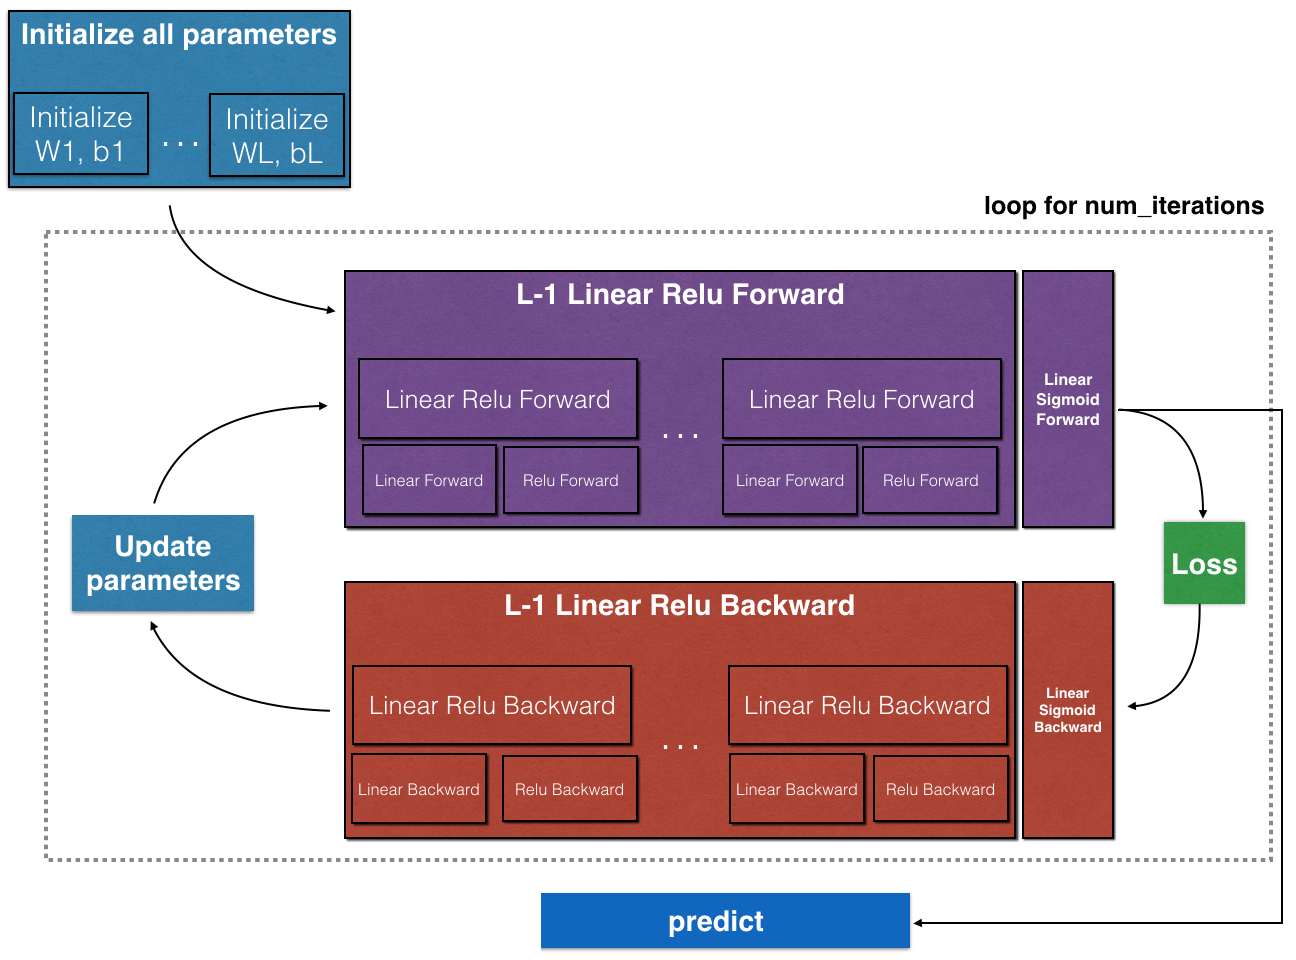

<a name='3'></a>
## 3 - Initialization

<a name='3-1'></a>
### 3.1 - 2-layer Neural Network

In [ ]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer

    Returns:
    parameters -- python dictionary containing parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """

    np.random.seed(1)

    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

<a name='3-2'></a>
### 3.2 - L-layer Neural Network

The initialization for a deeper L-layer neural network is more complicated because there are many more weight matrices and bias vectors. When completing the `initialize_parameters_deep` function, I had to make sure that my dimensions matched between each layer. For example, if the size of your input $X$ is $(12288, 209)$ (with $m=209$ examples) then:

<table style="width:100%">
    <tr>
        <td>  </td>
        <td> <b>Shape of W</b> </td>
        <td> <b>Shape of b</b>  </td>
        <td> <b>Activation</b> </td>
        <td> <b>Shape of Activation</b> </td>
    <tr>
    <tr>
        <td> <b>Layer 1</b> </td>
        <td> $(n^{[1]},12288)$ </td>
        <td> $(n^{[1]},1)$ </td>
        <td> $Z^{[1]} = W^{[1]}  X + b^{[1]} $ </td>
        <td> $(n^{[1]},209)$ </td>
    <tr>
    <tr>
        <td> <b>Layer 2</b> </td>
        <td> $(n^{[2]}, n^{[1]})$  </td>
        <td> $(n^{[2]},1)$ </td>
        <td>$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$ </td>
        <td> $(n^{[2]}, 209)$ </td>
    <tr>
       <tr>
        <td> $\vdots$ </td>
        <td> $\vdots$  </td>
        <td> $\vdots$  </td>
        <td> $\vdots$</td>
        <td> $\vdots$  </td>
    <tr>  
   <tr>
       <td> <b>Layer L-1</b> </td>
        <td> $(n^{[L-1]}, n^{[L-2]})$ </td>
        <td> $(n^{[L-1]}, 1)$  </td>
        <td>$Z^{[L-1]} =  W^{[L-1]} A^{[L-2]} + b^{[L-1]}$ </td>
        <td> $(n^{[L-1]}, 209)$ </td>
   <tr>
   <tr>
       <td> <b>Layer L</b> </td>
        <td> $(n^{[L]}, n^{[L-1]})$ </td>
        <td> $(n^{[L]}, 1)$ </td>
        <td> $Z^{[L]} =  W^{[L]} A^{[L-1]} + b^{[L]}$</td>
        <td> $(n^{[L]}, 209)$  </td>
    <tr>
</table>

When computing $W X + b$ in python, it carries out broadcasting. For example, if:

$$ W = \begin{bmatrix}
    w_{00}  & w_{01} & w_{02} \\
    w_{10}  & w_{11} & w_{12} \\
    w_{20}  & w_{21} & w_{22}
\end{bmatrix}\;\;\; X = \begin{bmatrix}
    x_{00}  & x_{01} & x_{02} \\
    x_{10}  & x_{11} & x_{12} \\
    x_{20}  & x_{21} & x_{22}
\end{bmatrix} \;\;\; b =\begin{bmatrix}
    b_0  \\
    b_1  \\
    b_2
\end{bmatrix}\tag{2}$$

Then $WX + b$ will be:

$$ WX + b = \begin{bmatrix}
    (w_{00}x_{00} + w_{01}x_{10} + w_{02}x_{20}) + b_0 & (w_{00}x_{01} + w_{01}x_{11} + w_{02}x_{21}) + b_0 & \cdots \\
    (w_{10}x_{00} + w_{11}x_{10} + w_{12}x_{20}) + b_1 & (w_{10}x_{01} + w_{11}x_{11} + w_{12}x_{21}) + b_1 & \cdots \\
    (w_{20}x_{00} + w_{21}x_{10} + w_{22}x_{20}) + b_2 &  (w_{20}x_{01} + w_{21}x_{11} + w_{22}x_{21}) + b_2 & \cdots
\end{bmatrix}\tag{3}  $$


In [ ]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network

    Returns:
    parameters -- python dictionary containing parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """

    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))


    return parameters

<a name='4'></a>
## 4 - Forward Propagation Module

<a name='4-1'></a>
### 4.1 - Linear Forward

Now that we have initialized the parameters, we can assemble the forward propagation module.

- LINEAR
- LINEAR -> ACTIVATION where ACTIVATION will be either ReLU or Sigmoid.
- [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID (whole model)

The linear forward module (vectorized over all the examples) computes the following equations:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{4}$$

where $A^{[0]} = X$.

In [ ]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """

    Z = np.dot(W, A) + b
    cache = (A, W, b)

    return Z, cache

<a name='4-2'></a>
### 4.2 - Linear-Activation Forward

In this notebook, I used two activation functions:

- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$.

- **ReLU**: The mathematical formula for ReLu is $A = RELU(Z) = max(0, Z)$.

In [ ]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """

    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    cache = (linear_cache, activation_cache)

    return A, cache

<a name='4-3'></a>
### 4.3 - L-Layer Model

For more convenience when implementing the $L$-layer Neural Net, we will need a function that replicates the previous one (`linear_activation_forward` with RELU) $L-1$ times, then follows that with one `linear_activation_forward` with SIGMOID.

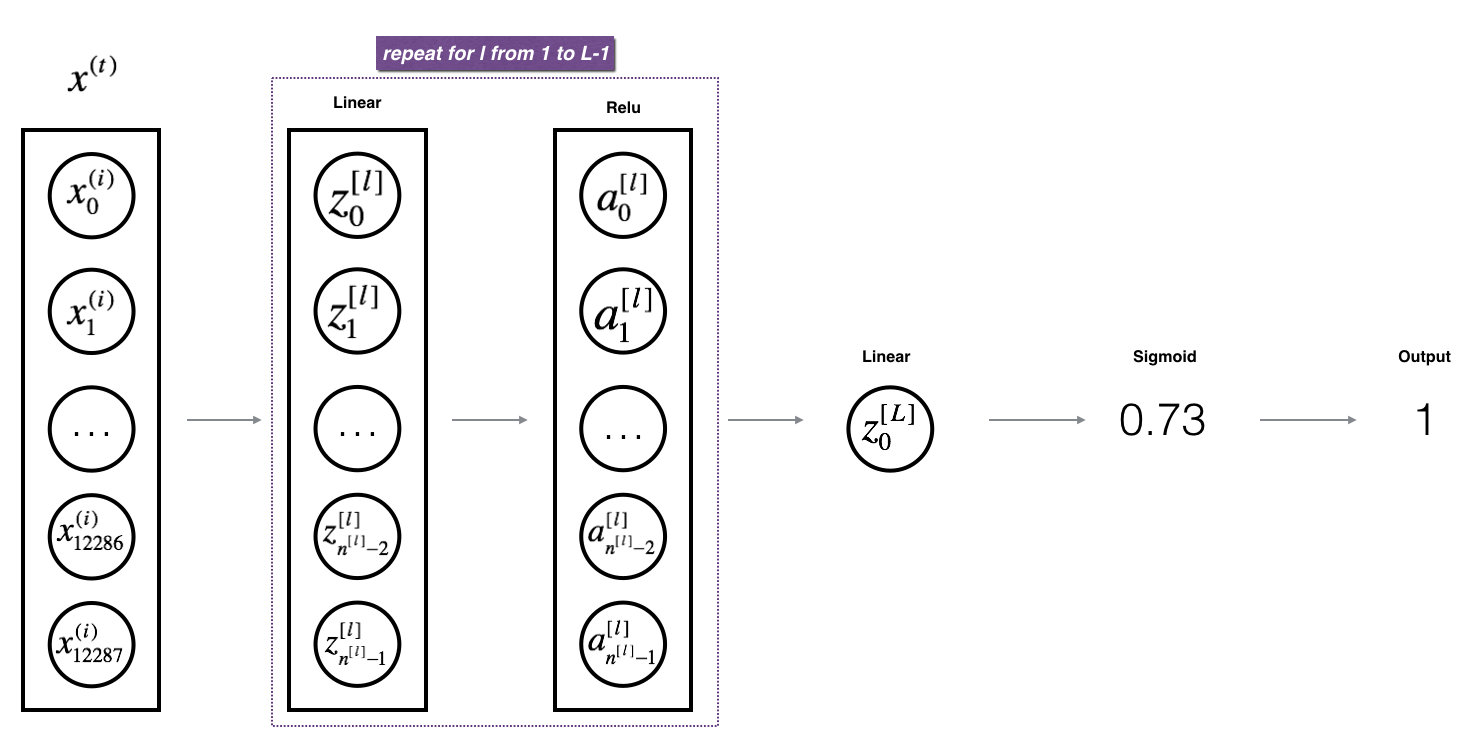

In [ ]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation

    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()

    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network


    # The for loop starts at 1 because layer 0 is the input
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], 'relu')
        caches.append(cache)

    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], 'sigmoid')
    caches.append(cache)

    return AL, caches

<a name='5'></a>
## 5 - Cost Function

Now we can implement forward and backward propagation. We will first build the cost function

In [ ]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """

    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (-1/m)*(np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL)))

    cost = np.squeeze(cost)


    return cost

<a name='6'></a>
## 6 - Backward Propagation Module

Backpropagation is used to calculate the gradient of the loss function with respect to the parameters.

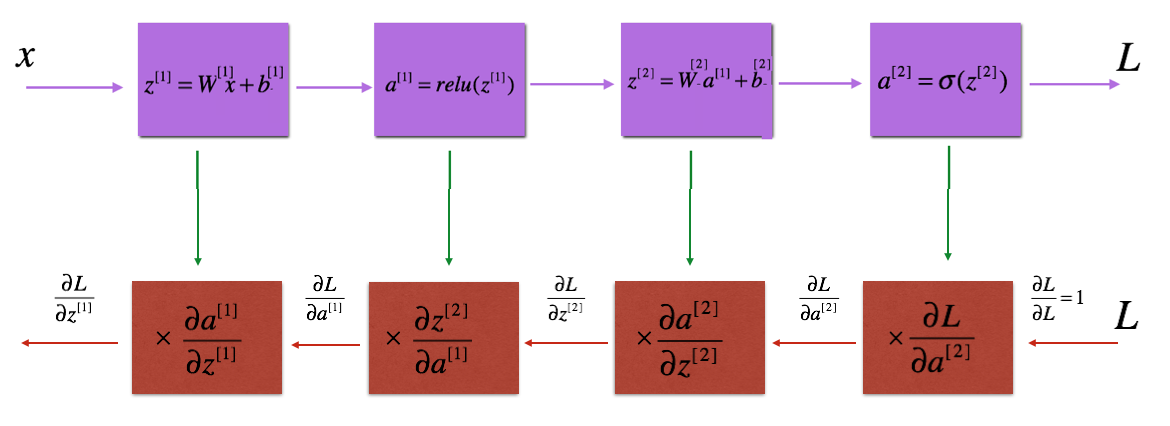

<a name='6-1'></a>
### 6.1 - Linear Backward

For layer $l$, the linear part is: $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ (followed by an activation).

Suppose if we have already calculated the derivative $dZ^{[l]} = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$. We then want to get $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$.

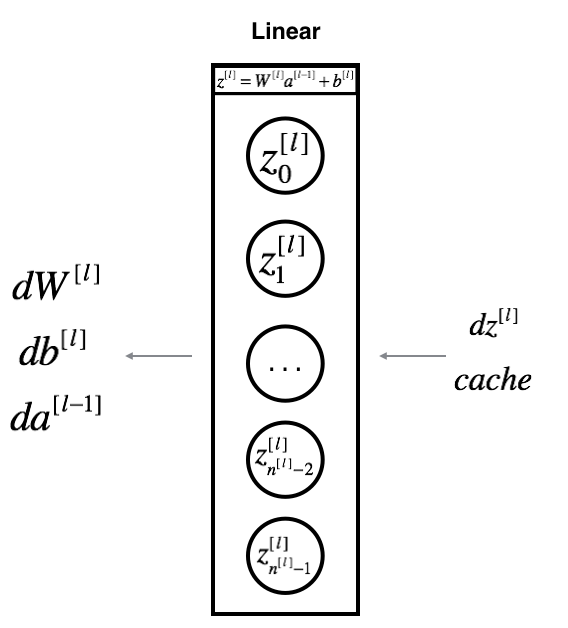


The three outputs $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$ are computed using the input $dZ^{[l]}$.

Here are the formulas I implemented:
$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{8}$$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{9}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{10}$$


$A^{[l-1] T}$ is the transpose of $A^{[l-1]}$.

In [ ]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*(np.dot(dZ, A_prev.T))
    db = (1/m)*(np.sum(dZ, axis=1, keepdims=True))
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

<a name='6-2'></a>
### 6.2 - Linear-Activation Backward


In [ ]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.

    Arguments:
    dA -- post-activation gradient for current layer l
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ =  relu_backward(dA, activation_cache)
        dA_prev, dW, db =  linear_backward(dZ, linear_cache)

    elif activation == "sigmoid":
        dZ =  sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db =  linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

<a name='6-3'></a>
### 6.3 - L-Model Backward


In [ ]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group

    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])

    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ...
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ...
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL

    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    current_cache = caches[L - 1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, 'sigmoid')
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp

    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)]
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, 'relu')
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp

    return grads

<a name='6-4'></a>
### 6.4 - Update Parameters

This is a simple step where we update the parameters of the model using gradient descent:

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{16}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{17}$$

where $\alpha$ is the learning rate.

After computing the updated parameters, we store them in the parameters dictionary.

In [ ]:
def update_parameters(params, grads, learning_rate):
    """
    Update parameters using gradient descent

    Arguments:
    params -- python dictionary containing parameters
    grads -- python dictionary containing gradients, output of L_model_backward

    Returns:
    parameters -- python dictionary containing updated parameters
                  parameters["W" + str(l)] = ...
                  parameters["b" + str(l)] = ...
    """
    parameters = params.copy()
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads['dW' + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads['db' + str(l+1)]

    return parameters